## Setting Up Your Python Environment

In [5]:
# %%capture
# # Install PyTorch with CUDA
# !pip install -q torch torchvision torchaudio

# # Install additional dependencies
# !pip install -q datasets matplotlib pandas pillow timm torcheval torchtnt==0.2.0 tqdm

# # Install utility packages
# !pip install -q cjm_pandas_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [1]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
import urllib.request

# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor
from cjm_torchvision_tfms.core import ResizeMax, PadSquare

# Import matplotlib for creating plots
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Import numpy 
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

from torchtnt.utils import get_module_summary
from torcheval.metrics import MulticlassAccuracy

# Import tqdm for progress bar
from tqdm.auto import tqdm

import wandb


## Setting Up the Project

### Setting a Random Number Seed

In [2]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [3]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

### Setting the Directory Paths

In [4]:
# The name for the project
project_name = f"pytorch-timm-image-classifier"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
dataset_dir = Path("Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Project Directory:": project_dir,
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-timm-image-classifier
Dataset Directory:,Datasets
Archive Directory:,Datasets\..\Archive


## Loading and Exploring the Dataset

### Setting the Dataset Path

In [5]:
# Set the name of the dataset
dataset_name = 'barks'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name.removesuffix("-zip")}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name.removesuffix("-zip")}')

# Creating a Series with the dataset name and paths and converting it to a DataFrame for display
pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/barks
Archive Path:,Datasets\..\Archive\barks.zip
Dataset Path:,Datasets\barks


### Downloading the Dataset

In [ ]:
import tarfile
import zipfile

# Function to extract .zip and .tar.gz files
def file_extract(fname, dest):
    if fname.suffix == ".zip":
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall(dest)
    elif fname.suffixes == ['.tar', '.gz'] or fname.suffix == '.tar':
        with tarfile.open(fname, 'r:gz') as tar_ref:
            tar_ref.extractall(dest)
    else:
        raise ValueError(f"Unsupported file format: {fname.suffixes}")

# Construct the HuggingFace Hub dataset URL
dataset_url = "https://huggingface.co/datasets/alyzbane/barks/resolve/main/barks.tar.gz"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_path)  # Assuming download_file is defined
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)  # Extract the .tar.gz file
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

### Get Image Folders

In [6]:
dataset_path = Path(r"Y:\ML\datasets\barks\Barkley")
img_folder_paths = [folder for folder in dataset_path.iterdir() if folder.is_dir()]

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image Folder": [folder.name for folder in img_folder_paths]})

,Image Folder
0,IPL
1,MNG
2,NRR
3,PLM
4,TPT


### Get Image File Paths

In [7]:
# Get a list of all image file paths from the image folders
class_file_paths = [get_img_files(folder) for folder in img_folder_paths]

# Get all image files in the 'img_dir' directory
img_paths = [
    file
    for folder in class_file_paths # Iterate through each image folder
    for file in folder # Get a list of image files in each image folder
]

# Print the number of image files
print(f"Number of Images: {len(img_paths)}")

# Display the first five entries using a Pandas DataFrame
pd.DataFrame(img_paths).head()

Number of Images: 1521


,0
0,Y:\ML\datasets\barks\Barkley\IPL\20240925_031716889_iOS.jpg
1,Y:\ML\datasets\barks\Barkley\IPL\20240925_031718151_iOS.jpg
2,Y:\ML\datasets\barks\Barkley\IPL\20240925_031719467_iOS.jpg
3,Y:\ML\datasets\barks\Barkley\IPL\20240925_031720530_iOS.jpg
4,Y:\ML\datasets\barks\Barkley\IPL\20240925_031722115_iOS.jpg


### Inspecting the Class Distribution

#### Get image classes

In [8]:
# Get the number of samples for each image class
class_counts_dict = {folder[0].parent.name:len(folder) for folder in class_file_paths}

# Get a list of unique labels
class_names = list(class_counts_dict.keys())

# Display the labels and the corresponding number of samples using a Pandas DataFrame
class_counts = pd.DataFrame.from_dict({'Count':class_counts_dict})
class_counts

,Count
IPL,305
MNG,356
NRR,308
PLM,276
TPT,276


#### Visualize the class distribution

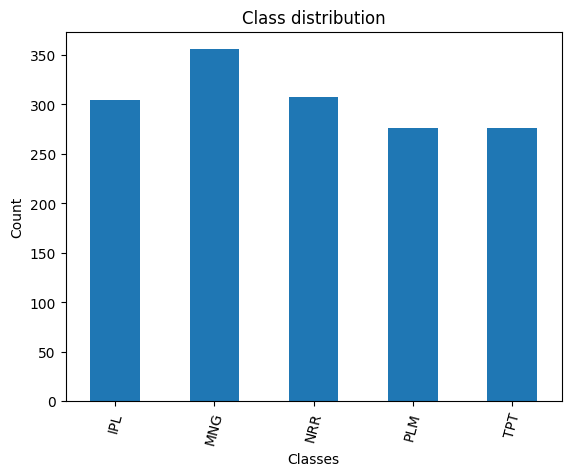

In [9]:
# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names)  # Set the x-axis tick labels
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.gca().legend().set_visible(False)
plt.show()

### Visualizing Sample Images

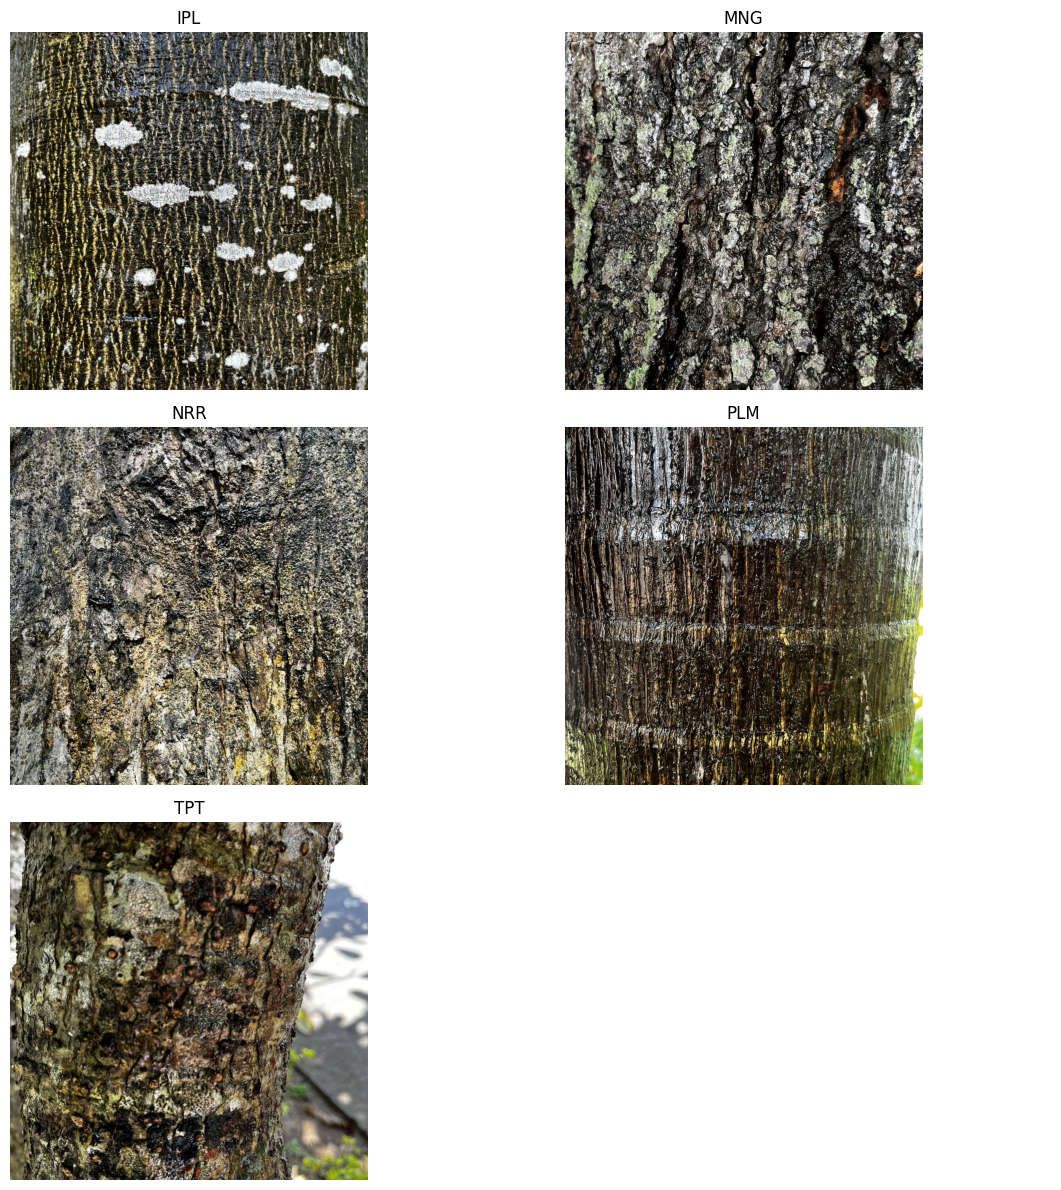

In [10]:
# Create a list to store the first image found for each class
sample_image_paths = [folder[0] for folder in class_file_paths]
sample_labels = [path.parent.stem for path in sample_image_paths]

# Calculate the number of rows and columns
grid_size = math.floor(math.sqrt(len(sample_image_paths)))
n_rows = grid_size+(1 if grid_size**2 < len(sample_image_paths) else 0)
n_cols = grid_size

# Create a figure for the grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,12))

for i, ax in enumerate(axs.flatten()):
    # If we have an image for this subplot
    if i < len(sample_image_paths) and sample_image_paths[i]:
        # Add the image to the subplot
        ax.imshow(np.array(Image.open(sample_image_paths[i])))
        # Set the title to the corresponding class name
        ax.set_title(sample_labels[i])
        # Remove the axis
        ax.axis('off')
    else:
        # If no image, hide the subplot
        ax.axis('off')

# Display the grid
plt.tight_layout()
plt.show()

## Selecting a Model

### Exploring Available Models

In [13]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

,0
0,resnet18.a1_in1k
1,resnet18.a2_in1k
2,resnet18.a3_in1k
3,resnet18.fb_ssl_yfcc100m_ft_in1k
4,resnet18.fb_swsl_ig1b_ft_in1k
5,resnet18.gluon_in1k
6,resnet18.tv_in1k
7,resnet18d.ra2_in1k


### Inspecting the Model Configuration

In [14]:
# Import the resnet module
from timm.models import resnet as model_family

# Define the base model variant to use
base_model = 'resnet18'
version = "a1_in1k"

# Get the default configuration of the chosen model
model_cfg = model_family.default_cfgs[base_model].default.to_dict()

# Show the default configuration values
pd.DataFrame.from_dict(model_cfg, orient='index')

,0
url,https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet18_a1_0-d63eafa0.pth
hf_hub_id,timm/
custom_load,False
input_size,"(3, 224, 224)"
test_input_size,"(3, 288, 288)"
fixed_input_size,False
interpolation,bicubic
crop_pct,0.95
test_crop_pct,1.0
crop_mode,center


### Retrieving Normalization Statistics

In [15]:
# Retrieve normalization statistics (mean and std) specific to the pretrained model
mean, std = model_cfg['mean'], model_cfg['std']
norm_stats = (mean, std)
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

### Loading the Model

In [16]:
# Create a pretrained ResNet model with the number of output classes equal to the number of class names
# 'timm.create_model' function automatically downloads and initializes the pretrained weights
model = timm.create_model(f'{base_model}.{version}', pretrained=True, num_classes=len(class_names))

# Set the device and data type for the model
model = model.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
model.device = device
model.name = f'{base_model}.{version}'

### Summarizing the Model

In [17]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs,Backward FLOPs,In size,Out size
0,ResNet,11.2 M,11.2 M,44.8 M,2.4 G,4.6 G,"[1, 3, 256, 256]","[1, 5]"
1,Conv2d,9.4 K,9.4 K,37.6 K,154 M,154 M,"[1, 3, 256, 256]","[1, 64, 128, 128]"
7,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
12,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
16,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
21,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
26,Conv2d,73.7 K,73.7 K,294 K,75.5 M,150 M,"[1, 64, 64, 64]","[1, 128, 32, 32]"
31,Conv2d,147 K,147 K,589 K,150 M,301 M,"[1, 128, 32, 32]","[1, 128, 32, 32]"
35,Conv2d,8.2 K,8.2 K,32.8 K,8.4 M,16.8 M,"[1, 64, 64, 64]","[1, 128, 32, 32]"
38,Conv2d,147 K,147 K,589 K,150 M,301 M,"[1, 128, 32, 32]","[1, 128, 32, 32]"


## Preparing the Data

### Training-Validation Split

In [19]:
# Shuffle the image paths
random.shuffle(img_paths)

# Define the percentage of the images that should be used for training, validation, and testing
train_pct = 0.8  # 80% for training
val_pct = 0.1    # 10% for validation
test_pct = 0.1   # 10% for testing

# Calculate the index at which to split the subset of image paths
train_split = int(len(img_paths) * train_pct)
val_split = train_split + int(len(img_paths) * val_pct)

# Split the subset of image paths into training, validation, and testing sets
train_paths = img_paths[:train_split]
val_paths = img_paths[train_split:val_split]
test_paths = img_paths[val_split:]

# Print the number of images in the training, validation, and testing sets
summary_df = pd.Series({
    "Training Samples:": len(train_paths),
    "Validation Samples:": len(val_paths),
    "Testing Samples:": len(test_paths)
}).to_frame()

# Display the summary DataFrame without showing the columns
summary_df.style.hide(axis='columns')

Training Samples:,1216
Validation Samples:,152
Testing Samples:,153


### Data Augmentation

#### Set training image size

In [20]:
train_sz = 224 # image size

#### Initialize image transforms

In [21]:
# Set the fill color for padding images
fill = (0,0,0)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=fill)

# # Create a TrivialAugmentWide object
trivial_aug = transforms.TrivialAugmentWide(fill=fill)

#### Test the transforms

In [ ]:
sample_img = Image.open(img_paths[11])
sample_img

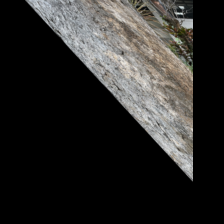

Source Image:,"(3024, 4032)"
Resized Image:,"(168, 224)"
Padded Image:,"(224, 224)"
Resized Padded Image:,"(224, 224)"


In [23]:
# Augment the image
augmented_img = trivial_aug(sample_img)

# Resize the image
resized_img = resize_max(augmented_img)

# Pad the image
padded_img = pad_square(resized_img)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img = resize(padded_img)

# Display the annotated image
display(resized_padded_img)

pd.Series({
    "Source Image:": sample_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [24]:
class ImageDataset(Dataset):
    """
    A PyTorch Dataset class for handling images.
    
    This class extends PyTorch's Dataset and is designed to work with image data. 
    It supports loading images, and applying transformations.

    Attributes:
        img_paths (list): List of image file paths.
        class_to_idx (dict): Dictionary mapping class names to class indices.
        transforms (callable, optional): Transformations to be applied to the images.
    """

    def __init__(self, img_paths, class_to_idx, transforms=None):
        """
        Initializes the ImageDataset with image keys and other relevant information.
        
        Args:
            img_paths (list): List of image file paths.
            class_to_idx (dict): Dictionary mapping class names to class indices.
            transforms (callable, optional): Transformations to be applied to the images.
        """
        super(Dataset, self).__init__()
        
        self._img_paths = img_paths
        self._class_to_idx = class_to_idx
        self._transforms = transforms

    def __len__(self):
        """
        Returns the number of items in the dataset.
        
        Returns:
            int: Number of items in the dataset.
        """
        return len(self._img_paths)
        
    def __getitem__(self, index):
        """
        Retrieves an item from the dataset at the specified index.
        
        Args:
            index (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image and its corresponding label.
        """
        img_path = self._img_paths[index]
        image, label = self._load_image(img_path)
        
        # Applying transformations if specified
        if self._transforms:
            image = self._transforms(image)

        return image, label

    def _load_image(self, img_path):
        """
        Loads an image from the provided image path.
        
        Args:
            img_path (string): Image path.
            Returns:
        tuple: A tuple containing the loaded image and its corresponding target data.
        """
        # Load the image from the file path
        image = Image.open(img_path).convert('RGB')
        
        return image, self._class_to_idx[img_path.parent.name]

### Image Transforms

In [25]:
# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    # pad_square, # Padding image, use this if your model will learn representations in correct aspect ratio
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(*norm_stats),
])

# Define the transformations for training and validation datasets
# Note: Data augmentation is performed only on the training dataset
train_tfms = transforms.Compose([
    # trivial_aug,
    resize_pad_tfm, 
    # transforms.RandomRotation(90),             # Randomly rotate the image by 0, 90, 180, or 270 degrees
    transforms.RandomHorizontalFlip(p=0.5),     # Randomly flip the image horizontally with a probability of 0.5
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15),  # Random color adjustments
    final_tfms
])
valid_tfms = transforms.Compose([
    resize_pad_tfm, 
    final_tfms
])

### Initialize Datasets

In [26]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = ImageDataset(train_paths, class_to_idx, train_tfms)
valid_dataset = ImageDataset(val_paths, class_to_idx, valid_tfms)
test_dataset = ImageDataset(test_paths, class_to_idx, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset),
    'Test dataset size:': len(test_dataset)}
).to_frame().style.hide(axis='columns')

Training dataset size:,1216
Validation dataset size:,152
Test dataset size:,153


### Inspect Samples

**Inspect training set sample**

Label: MNG


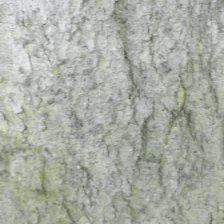

In [27]:
# Get the label for the first image in the training set
print(f"Label: {class_names[train_dataset[0][1]]}")

# Get the first image in the training set
TF.to_pil_image(denorm_img_tensor(train_dataset[4][0], *norm_stats))

**Inspect validation set sample**

Label: MNG


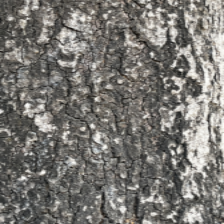

In [28]:
# Get the label for the first image in the validation set
print(f"Label: {class_names[valid_dataset[0][1]]}")

# Get the first image in the validation set
TF.to_pil_image(denorm_img_tensor(valid_dataset[0][0], *norm_stats))

### Training Batch Size

In [29]:
bs = 32

### Initialize DataLoaders

In [30]:
# Set the number of worker processes for loading data. This should be the number of CPUs available.
num_workers = multiprocessing.cpu_count()#//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    # 'num_workers': num_workers,  # Number of subprocesses to use for data loading
    # 'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)
test_dataloader = DataLoader(test_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
print(f'Number of batches in train DataLoader: {len(train_dataloader)}')
print(f'Number of batches in validation DataLoader: {len(valid_dataloader)}')
print(f'Number of batches in test DataLoader: {len(test_dataloader)}')

Number of batches in train DataLoader: 38
Number of batches in validation DataLoader: 5
Number of batches in test DataLoader: 5


## Fine-tuning the Model

### Define the Training Loop

#### Old Version

In [407]:
# # Function to run a single training/validation epoch
# def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch_id, is_training):
#     # Set model to training mode if 'is_training' is True, else set to evaluation mode
#     model.train() if is_training else model.eval()
    
#     # Reset the performance metric
#     metric.reset()
#     # Initialize the average loss for the current epoch 
#     epoch_loss = 0
#     # Initialize progress bar with total number of batches in the dataloader
#     progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")
    
#     # Iterate over data batches
#     for batch_id, (inputs, targets) in enumerate(dataloader):
#         # Move inputs and targets to the specified device (e.g., GPU)
#         inputs, targets = inputs.to(device), targets.to(device)
        
#         # Enables gradient calculation if 'is_training' is True
#         with torch.set_grad_enabled(is_training):
#             # Automatic Mixed Precision (AMP) context manager for improved performance
#             with autocast(torch.device(device).type):
#                 outputs = model(inputs) # Forward pass
#                 loss = torch.nn.functional.cross_entropy(outputs, targets) # Compute loss
        
#         # Update the performance metric
#         metric.update(outputs.detach().cpu(), targets.detach().cpu())
        
#         # If in training mode
#         if is_training:
#             if scaler:
#                 scaler.scale(loss).backward()
#                 scaler.step(optimizer)
#                 old_scaler = scaler.get_scale()
#                 scaler.update()
#                 new_scaler = scaler.get_scale()
#                 if new_scaler >= old_scaler:
#                     lr_scheduler.step()
#             else:
#                 loss.backward()
#                 optimizer.step()
#                 lr_scheduler.step()
                
#             optimizer.zero_grad()
        
#         loss_item = loss.item()
#         epoch_loss += loss_item
#         # Update progress bar
#         progress_bar.set_postfix(accuracy=metric.compute().item(), 
#                                  loss=loss_item, 
#                                  avg_loss=epoch_loss/(batch_id+1), 
#                                  lr=lr_scheduler.get_last_lr()[0] if is_training else "")
#         progress_bar.update()
        
#         # If loss is NaN or infinity, stop training
#         if is_training:
#             stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
#             assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message
        
#     progress_bar.close()
#     return epoch_loss / (batch_id + 1)

# # Main training loop
# def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, checkpoint_path, use_scaler=False):
#     # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
#     scaler = GradScaler() if device.type == 'cuda' and use_scaler else None
#     best_loss = float('inf')

#     # Iterate over each epoch
#     for epoch in tqdm(range(epochs), desc="Epochs"):
#         # Run training epoch and compute training loss
#         train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, is_training=True)
#         # Run validation epoch and compute validation loss
#         with torch.no_grad():
#             valid_loss = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, epoch, is_training=False)
        
#         # If current validation loss is lower than the best one so far, save model and update best loss
#         if valid_loss < best_loss:
#             best_loss = valid_loss
#             metric_value = metric.compute().item()
#             torch.save(model.state_dict(), checkpoint_path)
            
#             training_metadata = {
#                 'epoch': epoch,
#                 'train_loss': train_loss,
#                 'valid_loss': valid_loss, 
#                 'metric_value': metric_value,
#                 'learning_rate': lr_scheduler.get_last_lr()[0],
#                 'model_architecture': model.name
#             }
            
#             # Save best_loss and metric_value in a JSON file
#             with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
#                 json.dump(training_metadata, f)

#     # If the device is a GPU, empty the cache
#     if device.type != 'cpu':
#         getattr(torch, device.type).empty_cache()

### Stable

In [31]:
def plot_metrics(epochs, train_losses, valid_losses, train_accuracies, valid_accuracies, checkpoint_path):
    # Generate an array of epoch numbers
    epoch_range = np.arange(1, epochs + 1)
    
    # Plot training and validation losses
    plt.figure(figsize=(14, 6))
    
    # Subplot for Loss
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epoch_range, valid_losses, label='Valid Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, train_accuracies, label='Train Accuracy', color='blue', marker='o')
    plt.plot(epoch_range, valid_accuracies, label='Valid Accuracy', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    
    # Save the plot
    plots_dir = os.path.join(checkpoint_path.parent, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    plot_filename = os.path.join(plots_dir, 'training_results.png')
    plt.savefig(plot_filename, dpi=300)
    
    plt.show()
    print(f"Plots saved at: {plot_filename}")

In [32]:
def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch_id, is_training, loss_fn):
    # Set model to training mode if 'is_training' is True, else set to evaluation mode
    model.train() if is_training else model.eval()
    
    # Reset the performance metric
    metric.reset()
    # Initialize the average loss for the current epoch 
    epoch_loss = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")
    
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device (e.g., GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        # Enables gradient calculation if 'is_training' is True
        with torch.set_grad_enabled(is_training):
            # Automatic Mixed Precision (AMP) context manager for improved performance
            with autocast(torch.device(device).type):
                outputs = model(inputs)  # Forward pass
                loss = loss_fn(outputs, targets)  # Compute loss
    
        # Update the performance metric
        metric.update(outputs.detach().cpu(), targets.detach().cpu())
        
        # If in training mode
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            optimizer.zero_grad()

        loss_item = loss.item()
        epoch_loss += loss_item
        accuracy = metric.compute().item()  # Calculate current accuracy
        progress_bar.set_postfix(accuracy=accuracy, 
                                 loss=loss_item, 
                                 avg_loss=epoch_loss/(batch_id+1), 
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()
        
        # If loss is NaN or infinity, stop training
        assert not math.isnan(loss_item) and math.isfinite(loss_item), f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."

    progress_bar.close()
    return epoch_loss / (batch_id + 1), accuracy  # Return loss and accuracy

In [33]:
# # Main training loop
# def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, checkpoint_path, use_scaler=False):
#     # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
#     scaler = GradScaler() if device.type == 'cuda' and use_scaler else None
#     best_loss = float('inf')
    
#     # Iterate over each epoch
#     for epoch in tqdm(range(epochs), desc="Epochs"):
#         # Run training epoch and compute training loss
#         train_loss, train_accuracy = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, is_training=True)
#         # Run validation epoch and compute validation loss
#         with torch.no_grad():
#             valid_loss, valid_accuracy = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, epoch, is_training=False)

#         # If current validation loss is lower than the best one so far, save model and update best loss
#         if valid_loss < best_loss:
#             best_loss = valid_loss
            
#             # Save model state and metrics to JSON file
#             training_metadata = {
#                 'epoch': epoch,
#                 'train_loss': train_loss,
#                 'valid_loss': valid_loss,
#                 'train_accuracy': train_accuracy,
#                 'valid_accuracy': valid_accuracy,
#                 'learning_rate': lr_scheduler.get_last_lr()[0],
#                 'model_architecture': model.name,
#             }
            
#             torch.save(model.state_dict(), checkpoint_path)
            
#             # Save best_loss and metric_value in a JSON file
#             with open(Path(checkpoint_path.parent / 'training_metadata.json'), 'w') as f:
#                 json.dump(training_metadata, f)
    
#     # If the device is a GPU, empty the cache
#     if device.type != 'cpu':
#         getattr(torch, device.type).empty_cache()

In [34]:
def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, checkpoint_path, loss_fn, use_scaler=False):
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')
    
    # Initialize Weights and Biases (W&B)
    wandb.init(project='timm-models', anonymous="allow", name=model.__class__.__name__, config={
        'epochs': epochs,
        'learning_rate': lr_scheduler.get_last_lr()[0],
        'architecture': model.__class__.__name__,
    })

    # Lists to store metrics for plotting
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    # Iterate over each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run training epoch and compute training loss
        train_loss, train_accuracy = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, loss_fn=loss_fn, is_training=True)
        # Run validation epoch and compute validation loss
        with torch.no_grad():
            valid_loss, valid_accuracy = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, epoch, loss_fn=loss_fn, is_training=False)
        
        # Append metrics for plotting later
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        # Log metrics to W&B
        wandb.log({
            'epoch': epoch,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'train_accuracy': train_accuracy,
            'valid_accuracy': valid_accuracy,
            'learning_rate': lr_scheduler.get_last_lr()[0]
        }, steps=epoch)
        
        # If current validation loss is lower than the best one so far, save model and update best loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            
            # Save model state and metrics to JSON file
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'train_accuracy': train_accuracy,
                'valid_accuracy': valid_accuracy,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.__class__.__name__,
            }
            
            torch.save(model.state_dict(), checkpoint_path)
            
            # Save best_loss and metric_value in a JSON file
            with open(Path(checkpoint_path).parent / 'training_metadata.json', 'w') as f:
                json.dump(training_metadata, f, indent=4)
    
    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()
    
    # Plot the training and validation metrics
    plot_metrics(epochs, train_losses, valid_losses, train_accuracies, valid_accuracies, checkpoint_path)
    
    # Finish W&B logging session
    wandb.finish()

### Trainer

In [372]:

# class Trainer:
#     def __init__(self, model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, checkpoint_path, use_scaler=False, class_weights=None, clear_output=True, display=True, patience_counter=3):
#         self.model = model
#         self.train_dataloader = train_dataloader
#         self.valid_dataloader = valid_dataloader
#         self.optimizer = optimizer
#         self.metric = metric
#         self.lr_scheduler = lr_scheduler
#         self.device = device
#         self.epochs = epochs
#         self.checkpoint_path = checkpoint_path
#         self.use_scaler = use_scaler
        
#         # Initialize a gradient scaler for mixed-precision training if applicable
#         self.scaler = GradScaler() if device.type == 'cuda' and use_scaler else None
        
#         # Store class weights if provided
#         self.class_weights = class_weights

#     def run_epoch(self, dataloader, is_training):
#         self.model.train() if is_training else self.model.eval()
#         self.metric.reset()
#         epoch_loss = 0
        
#         with tqdm(total=len(dataloader), desc="Train" if is_training else "Eval") as progress_bar:
#             for batch_id, (inputs, targets) in enumerate(dataloader):
#                 inputs, targets = inputs.to(self.device), targets.to(self.device)
#                 with torch.set_grad_enabled(is_training):
#                     with autocast(torch.device(self.device).type):
#                         outputs = self.model(inputs)  # Forward pass

#                         # Compute loss with class weights if provided
#                         if self.class_weights is not None:
#                             loss = torch.nn.functional.cross_entropy(outputs, targets, weight=self.class_weights)
#                         else:
#                             loss = torch.nn.functional.cross_entropy(outputs, targets)  # Compute loss without weights

#                 # Update the performance metric
#                 self.metric.update(outputs.detach().cpu(), targets.detach().cpu())

#                 # If in training mode
#                 if is_training:
#                     if self.scaler:
#                         self.scaler.scale(loss).backward()
#                         self.scaler.step(self.optimizer)
#                         old_scaler = self.scaler.get_scale()
#                         self.scaler.update()
#                         new_scaler = self.scaler.get_scale()
#                         if new_scaler >= old_scaler:
#                             self.lr_scheduler.step()
#                     else:
#                         loss.backward()
#                         self.optimizer.step()
#                         self.lr_scheduler.step()

#                     self.optimizer.zero_grad()

#                 loss_item = loss.item()
#                 epoch_loss += loss_item
#                 accuracy = self.metric.compute().item()  # Calculate current accuracy
                
#                 # Update progress bar with metrics
#                 progress_bar.set_postfix(accuracy=accuracy,
#                                           loss=loss_item,
#                                           avg_loss=epoch_loss / (batch_id + 1),
#                                           lr=self.lr_scheduler.get_last_lr()[0] if is_training else "")
#                 progress_bar.update()

#                 assert not math.isnan(loss_item) and math.isfinite(loss_item), f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."

#         return epoch_loss / (batch_id + 1), accuracy  # Return loss and accuracy

#     def train(self):
#         best_loss = float('inf')
        
#         training_metrics = {}
#         df_metrics = pd.DataFrame()
#         training_state = []
        
#         # Wandb Visualization
#         wandb.init(project="timm-models", anonymous="allow") 

#         for epoch in tqdm(range(self.epochs), desc="Epochs"):
#             train_loss, train_accuracy = self.run_epoch(self.train_dataloader, is_training=True)
            
#             with torch.no_grad():
#                 valid_loss, valid_accuracy = self.run_epoch(self.valid_dataloader, is_training=False)

#             # Save metrics for plotting later
#             training_metrics[epoch] = {
#                 'train': {'loss': train_loss, 'accuracy': train_accuracy},
#                 'validation': {'loss': valid_loss, 'accuracy': valid_accuracy}
#             }
#             training_state.append({
#                     'epoch': epoch,
#                     'train_loss': train_loss,
#                     'valid_loss': valid_loss,
#                     'train_accuracy': train_accuracy,
#                     'valid_accuracy': valid_accuracy
#             })
            

#             # If current validation loss is lower than the best one so far
#             if valid_loss < best_loss:
#                 best_loss = valid_loss
#                 patience_counter = 0
#                 # Save model state and metrics to JSON file
#                 training_metadata = {
#                     'epoch': epoch,
#                     'train_loss': train_loss,
#                     'valid_loss': valid_loss,
#                     'train_accuracy': train_accuracy,
#                     'valid_accuracy': valid_accuracy,
#                     'learning_rate': self.lr_scheduler.get_last_lr()[0],
#                     'model_architecture': self.model.name,
#                 }
                
#                 torch.save(self.model.state_dict(), self.checkpoint_path)
                
#                  # Save metadata to JSON
#                 with open(Path(self.checkpoint_path).parent / 'training_metadata.json', 'w') as f:
#                     json.dump(training_metrics, f, indent=4)  # Save the list, not individual records
                    
#             elif valid_loss == best_loss:
#                 patience_counter += 1  # Increment counter if validation loss is the same
                
#                 # Check if patience limit has been reached
#                 if patience_counter >= 3:  # You can adjust this value as needed
#                     print(f"Early stopping triggered after {epoch} epochs.")
#                     break

#             df_row = pd.DataFrame([training_metadata])
#             df_metrics = pd.concat([df_metrics, df_row], ignore_index=True)
            
#             if hasattr(self, 'clear_output') and hasattr(self, 'display'):  # Only if running in a Jupyter environment
#                 if self.clear_output and self.display:
#                     self.clear_output(wait=True)
#                     self.display(pd.DataFrame(training_state))

#             # Log metrics to wandb
#             wandb.log({
#                 "train_loss": train_loss,
#                 "valid_loss": valid_loss,
#                 "train_accuracy": train_accuracy,
#                 "valid_accuracy": valid_accuracy,
#                 "learning_rate": self.lr_scheduler.get_last_lr()[0]
#             }, step=epoch)  # Log with epoch as step
        
#         wandb.finish()
        
#         # Plotting results after training completes
#         self.plot_results(training_metrics)

#     def plot_results(self, training_metrics):
#         epochs = list(training_metrics.keys())
#         train_losses = [metrics['train']['loss'] for metrics in training_metrics.values()]
#         val_losses = [metrics['validation']['loss'] for metrics in training_metrics.values()]
#         train_accuracies = [metrics['train']['accuracy'] for metrics in training_metrics.values()]
#         val_accuracies = [metrics['validation']['accuracy'] for metrics in training_metrics.values()]

#         plt.figure(figsize=(14, 6))

#         # Plot training and evaluation losses
#         plt.subplot(1, 2, 1)
#         plt.plot(epochs, train_losses, label='Train Loss', color='red', marker='o')
#         plt.plot(epochs, val_losses, label='Eval Loss', color='orange', marker='o')
#         plt.xlabel('Epoch', fontsize=12)
#         plt.ylabel('Loss', fontsize=12)
#         plt.title('Training and Evaluation Loss', fontsize=14)
#         plt.legend()
#         plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

#         # Plot training and evaluation accuracies
#         plt.subplot(1, 2, 2)
#         plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
#         plt.plot(epochs, val_accuracies, label='Eval Accuracy', color='green', marker='o')
#         plt.xlabel('Epoch', fontsize=12)
#         plt.ylabel('Accuracy', fontsize=12)
#         plt.title('Training and Evaluation Accuracies', fontsize=14)
#         plt.legend()
#         plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

#         # Adjust layout and spacing
#         plt.tight_layout()
        
#         # Save the figure with high resolution
#         plt.savefig(f"{self.checkpoint_path.parent}/train_and_eval.jpg", dpi=300)

#         # Show the plot
#         plt.show()

### Set the Model Checkpoint Path

In [39]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{base_model}_{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

pytorch-timm-image-classifier\resnet18_2024-10-07_04-38-00\resnet18.a1_in1k.pth


### Saving the Class Labels

In [40]:
# Save class labels
class_labels = {"classes": list(class_names)}

# Set file path
class_labels_path = checkpoint_dir/f"{dataset_name}-classes.json"

# Save class labels in JSON format
with open(class_labels_path, "w") as write_file:
    json.dump(class_labels, write_file)
    
print(class_labels_path)

pytorch-timm-image-classifier\resnet18_2024-10-07_04-38-00\barks-classes.json


### Calculating Class Weights for Imbalanced Datset

In [41]:
from collections import Counter
import numpy as np

def calculate_class_weights(train_dataset, class_to_idx):
    """
    Calculate class weights for imbalanced datasets based on the training data.
    
    Args:
        train_dataset (Dataset): The training dataset containing images and labels.
        class_to_idx (dict): Dictionary mapping class names to class indices.
    
    Returns:
        np.array: An array containing the class weights.
    """
    # Create a list of all class indices for images in the training dataset
    class_counts = Counter([class_to_idx[Path(img_path).parent.name] for img_path in train_dataset._img_paths])
    
    # Get total number of samples
    total_samples = len(train_dataset)

    # Compute the class weights: inverse frequency
    class_weights = {class_idx: total_samples / count for class_idx, count in class_counts.items()}
    
    # Normalize the weights to sum up to 1 (optional)
    total_weight_sum = sum(class_weights.values())
    class_weights = {class_idx: weight / total_weight_sum for class_idx, weight in class_weights.items()}

    # Convert the dictionary to a list of weights where index represents the class
    weights_list = np.zeros(len(class_to_idx))
    for class_idx, weight in class_weights.items():
        weights_list[class_idx] = weight
        
    return weights_list, class_counts  # Return both weights and counts

# Calculate class weights
class_weights, class_counts = calculate_class_weights(train_dataset, class_to_idx)

# Create a mapping of class indices to weights for better visualization
class_index_to_weight = {i: weight for i, weight in enumerate(class_weights)}
class_weights_tensor = torch.tensor(class_weights, dtype=dtype).to(device)

# Print class counts and corresponding weights
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)
print("Class Weights Tensor:", class_weights_tensor)

# Optionally, print in a more structured way
print("\nClass Index  | Class Count  | Class Weight")
for idx in range(len(class_weights)):
    count = class_counts[idx] if idx in class_counts else 0
    weight = class_weights[idx]
    print(f"{idx:<12} | {count:<12} | {weight:.6f}")

Class Counts: Counter({1: 287, 2: 248, 0: 236, 4: 227, 3: 218})
Class Weights: [0.20424299 0.16794894 0.19436026 0.22110709 0.21234073]
Class Weights Tensor: tensor([0.2042, 0.1679, 0.1944, 0.2211, 0.2123], device='cuda:0')

Class Index  | Class Count  | Class Weight
0            | 236          | 0.204243
1            | 287          | 0.167949
2            | 248          | 0.194360
3            | 218          | 0.221107
4            | 227          | 0.212341


### Configure the Training Parameters

In [47]:
# Learning rate for the model
lr = 2e-4

# Number of training epochs
epochs = 20

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=0.1*lr, 
                                                   total_steps=epochs*len(train_dataloader))
# Define the loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Performance metric: Multiclass Accuracy
metric = MulticlassAccuracy()

### Train the Model

In [48]:
train_loop(model=model, 
           train_dataloader=train_dataloader, 
           valid_dataloader=valid_dataloader, 
           optimizer=optimizer, 
           metric=metric, 
           lr_scheduler=lr_scheduler, 
           device=torch.device(device), 
           epochs=epochs, 
           checkpoint_path=checkpoint_path, 
           loss_fn=loss_fn,
           use_scaler=True)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

AssertionError: Loss is NaN or infinite at epoch 0, batch 4. Stopping training.

In [480]:

# # Usage example (assuming other variables are initialized)
# trainer = Trainer(model=model,
#                   train_dataloader=train_dataloader,
#                   valid_dataloader=valid_dataloader,
#                   optimizer=optimizer,
#                   metric=metric,
#                   lr_scheduler=lr_scheduler,
#                   device=torch.device(device),
#                   epochs=epochs,
#                   checkpoint_path=checkpoint_path,
#                   use_scaler=True,
#                  )

# trainer.train()

In [459]:
# # Assuming you have already defined your model, dataloaders, optimizer, etc.

# # Initialize the Trainer
# trainer = Trainer(
#     model=model,
#     train_dataloader=train_dataloader,
#     valid_dataloader=valid_dataloader,
#     optimizer=optimizer,
#     metric=metric,  # Replace with your desired metric
#     lr_scheduler=lr_scheduler,
#     device=torch.device(device), 
#     epochs=10,
#     checkpoint_path=checkpoint_path,
#     use_scaler=True,  # Enable mixed-precision training if needed
#     clear_output=True,  # Clear output before printing new epoch stats
#     display=True,  # Display training stats at the end of each epoch
#     patience_counter=3,
#     class_weights=class_weights_tensor  # Use early stopping
# )

# # Start the training process
# trainer.train()

## Visualization

In [49]:
wandb.finish()

ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

## Making Predictions with the Model

In [ ]:
# Choose an item from the validation set
test_file = val_paths[0]

# Open the test file
test_img = Image.open(test_file).convert('RGB')

# Set the minimum input dimension for inference 
input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(input_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = class_names[torch.argmax(pred_scores)]

# Display the image
display(test_img)

print(f"Predicted Class: {pred_class}")

# Print the prediction data as a Pandas DataFrame for easy formatting
confidence_score_df = pd.DataFrame({
    'Confidence Score':{
        name:f'{score*100:.2f}%' for name, score in zip(class_names, pred_scores.cpu().numpy()[0])
    }
})
confidence_score_df

### Testing the Model on New Data

In [ ]:
file_name = 'pexels-elina-volkova-16191659.jpg'
# file_name = 'pexels-joshua-roberts-12922530.jpg'
# file_name = 'pexels-luke-barky-2899727.jpg'
# file_name = 'pexels-ketut-subiyanto-4584599.jpg'
# file_name = 'pexels-nataliya-vaitkevich-5411990.jpg'
# file_name = 'pexels-darina-belonogova-7886753.jpg'
# file_name = 'pexels-katrin-bolovtsova-6706013.jpg'
# file_name = 'pexels-leo-vinicius-3714450.jpg'
# file_name = 'pexels-diva-plavalaguna-6937816.jpg'

test_img_url = f"https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/{file_name}"
test_img_path = Path(file_name)

if test_img_path.is_file():
    print("Image already exists.")
else:
    urllib.request.urlretrieve(test_img_url, test_img_path)
    print("Image downloaded.")

test_img = Image.open(test_img_path)
test_img

In [ ]:
# Set the minimum input dimension for inference 
infer_sz = train_sz

inp_img = resize_img(test_img.copy(), infer_sz)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = class_names[torch.argmax(pred_scores)]

# Display the image
display(test_img)

print(f"Predicted Class: {pred_class}")

# Print the prediction data as a Pandas DataFrame for easy formatting
confidence_score_df = pd.DataFrame({
    'Confidence Score':{
        name:f'{score*100:.2f}%' for name, score in zip(class_names, pred_scores.cpu().numpy()[0])
    }
})
confidence_score_df

In [ ]:
# Set the minimum input dimension for inference 
infer_sz = train_sz

inp_img = resize_img(test_img.copy(), infer_sz)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = class_names[torch.argmax(pred_scores)]

# Display the image
display(test_img)

print(f"Predicted Class: {pred_class}")

# Print the prediction data as a Pandas DataFrame for easy formatting
confidence_score_df = pd.DataFrame({
    'Confidence Score':{
        name:f'{score*100:.2f}%' for name, score in zip(class_names, pred_scores.cpu().numpy()[0])
    }
})
confidence_score_df